In [133]:
%load_ext autoreload
%autoreload 2

import os
from datetime import datetime
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.tensorboard import SummaryWriter

from market_dynamics import bs_delta, bs_generator, bs_call_price, garch_generator
from get_data import get_option_data
from data import SimulationData
from utils import call_payoff, stochastic_integral
from models import ControlNet
from train import train, test
from evaluation import get_eval_data

import seaborn as sns

import yfinance as yf
from arch import arch_model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [134]:
current_time = datetime.now().strftime('%b%d_%H-%M-%S')
comment = ""
log_dir = os.path.join('experiments', current_time + '_' + comment)
writer = SummaryWriter(log_dir)

In [135]:
ticker = yf.Ticker('^GSPC')
hist = ticker.history(period='1y', start='2013-03-05', end='2018-01-02')
initial_value = hist.Close.iloc[-1]
rets = 100 * hist.Close.pct_change().dropna()
rets.shape[0]==1217 #Check if is matches with the paper

True

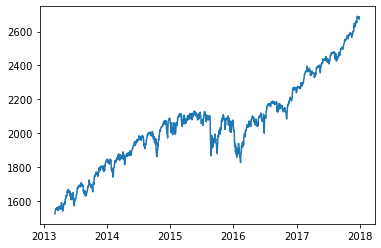

In [136]:
plt.plot(hist.Close)

In [137]:
fit_model = arch_model(rets, p=1, o=1, q=1, dist='t') #Right now fit to full data set, o=1 for gjr-garch
res = fit_model.fit(disp='off')
params = res.params

In [138]:
params

mu          4.937301e-02
omega       2.947883e-02
alpha[1]    1.055132e-11
gamma[1]    3.811128e-01
beta[1]     7.770165e-01
nu          5.719110e+00
Name: params, dtype: float64

In [139]:
h_params = {"N_SIM": 2 * 10**7, #The parameters as specificied in the paper
            "RF": 0,
            "N_DIMS": 2,
            "FC_DIM": 20,
            "LR": 0.0001,
            "GAMMA": 1,
            "EPOCHS": 40,
            "EPOCHS_2": 5, 
            "BATCH_SIZE": 256,}

In [140]:
strike = np.ceil(initial_value * 1.02)
sigma = (res._volatility[-1] / 100) * (252**0.5)
n_steps = 50
price = bs_call_price(n_steps, initial_value, sigma, h_params["RF"], strike)
initial_value, strike, sigma, price

(2673.610107421875, 2728.0, 0.06413026856822653, 7.0684978380948)

In [142]:
bs_params = {"n_simulations": h_params["N_SIM"],
                  "n_steps": n_steps,
                  "initial_value": initial_value,
                  "sigma": sigma,
                  }

garch_params = {"n_simulations": h_params["N_SIM"],
                "n_steps": n_steps,
                "initial_value": initial_value,
                "params": params,}

price_params = {"n_steps": n_steps,
                "initial_value": initial_value,
                "sigma": sigma,
                "rf": h_params["RF"],
                "strike": strike,
                }

payoff_params = {"strike": strike}

dt = SimulationData(garch_generator, garch_params, lambda x: x, {"x": price}, call_payoff, payoff_params, take_log=True)
data_loader_train = DataLoader(dt, batch_size=h_params["BATCH_SIZE"], shuffle=True, pin_memory=True)

In [149]:
cn = ControlNet(n_steps, 1, [20, 20], 1, learn_price=True)
optimizer = Adam(cn.parameters(), lr=0.0001)
scheduler = ExponentialLR(optimizer, gamma=1)
criterion = torch.nn.MSELoss()

EPOCHS = 40

In [150]:
train(data_loader_train, cn, criterion , optimizer, EPOCHS, writer, scheduler)

Epoch 0: : 0batch [00:08, ?batch/s]/opt/anaconda3/envs/deep_hedging/lib/python3.8/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 0: : 333batch [18:27,  3.32s/batch, loss=8.06e+3]


KeyboardInterrupt: 